| Status                             | Meaning                         | What it means in your data                                                                         |
| ---------------------------------- | ------------------------------- | -------------------------------------------------------------------------------------------------- |
| **200 OK**                         | Request succeeded               | The page or API endpoint was returned correctly.                                                   |
| **304 Not Modified**               | Cached version is still valid   | The client already had the resource and the server said “no change”. Common for static files.      |
| **302 Found (Temporary Redirect)** | Redirect to another URL         | The server redirected the user (e.g., login, HTTPS redirect, or URL change).                       |
| **404 Not Found**                  | Resource does not exist         | Broken links, missing pages, bad URLs, or crawlers probing random paths.                           |
| **403 Forbidden**                  | Access denied                   | The client is blocked or lacks permission (IP blocked, auth required).                             |
| **500 Internal Server Error**      | Server crashed while processing | Bug, memory error, timeout, or bad backend logic.                                                  |
| **501 Not Implemented**            | Method not supported            | The server doesn’t recognize the request method (e.g., PUT on a server that only allows GET/POST). |
| **400 Bad Request**                | Malformed request               | Invalid syntax, missing parameters, or corrupted requests.                                         |


After Normalized: 

200 -> Success

304 -> No Change

302 -> Redirected

404 -> Not Found

Others -> Error

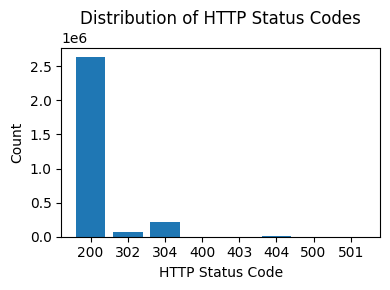

In [52]:
status_counts = df["status"].value_counts().sort_index()

plt.figure(figsize=(4, 3))
plt.bar(status_counts.index.astype(str), status_counts.values)

plt.xlabel("HTTP Status Code")
plt.ylabel("Count")
plt.title("Distribution of HTTP Status Codes")
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd 
import numpy as np
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA 
from PyEMD.EMD import EMD
import torch
import torch.nn as nn
import torch.optim as optim

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from shared_functions.gg_sheet_drive import *

In [22]:
def read_csv(name = 'train', interval = '5min'): # for some random reasons I have to create a read_csv function, nice  ¯\_(ツ)_/¯

    df = pd.read_csv(f"D:/Study/Education/Projects/DataFlow/DataFlow_2026/data/autoscaling/cleaned/{name}.csv")

    df['time'] = pd.to_datetime(df['time'])
    df['status'] = df['status'].astype(int)
    df['size'] = df['size'].astype(float)

    # Time resampling for forecasting
    df_agg = (
        df
        .set_index("time")
        .groupby("status_label")
        .resample(interval, level=0)["size"]
        .mean()
        .reset_index()
        .fillna(0)
    )

    return df, df_agg

train, train_time = read_csv('train')
test, test_time = read_csv('test')

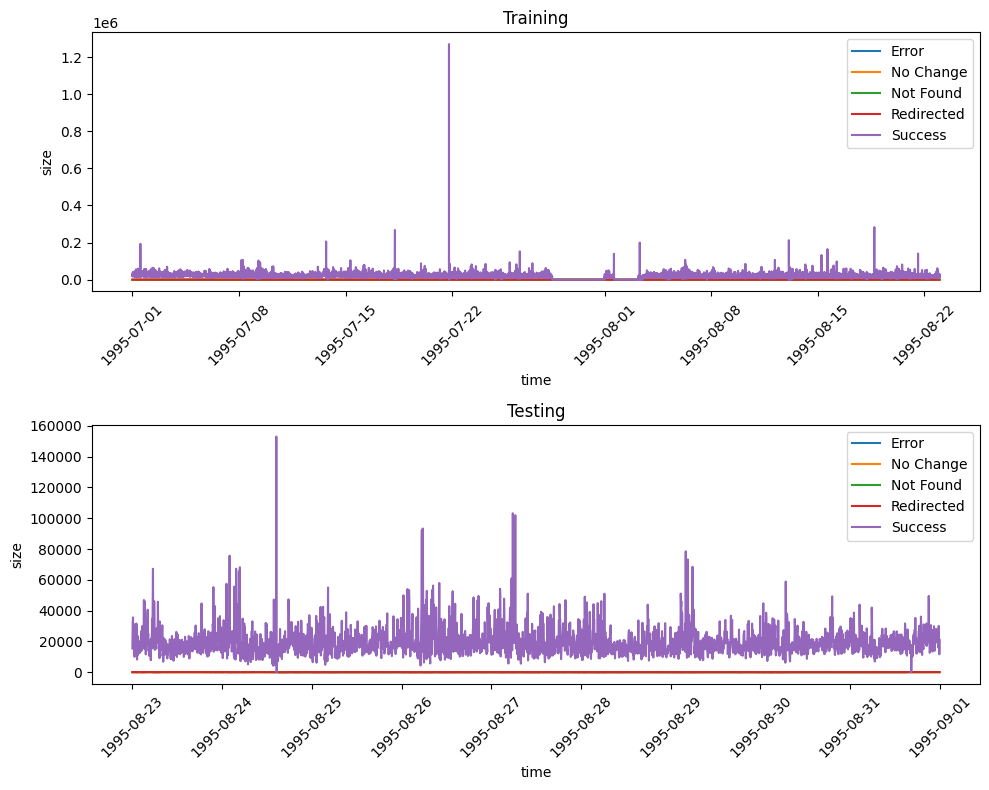

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.lineplot(data=train_time, x="time", y="size",
             hue="status_label", ax=axes[0])
axes[0].set_title("Training")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc="upper right")

sns.lineplot(data=test_time, x="time", y="size",
             hue="status_label", ax=axes[1])
axes[1].set_title("Testing")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Looks predictable?

#### Extract some necessary features for reporting (maybe no use in forecasting)


In [ ]:
# hits/sec

hits_per_sec = df.set_index("time").resample("1S").size()

C:\Users\admin\AppData\Local\Temp\ipykernel_1624\1729525887.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  hits_per_sec = df.set_index("time").resample("1S").size()


In [ ]:
# error rate (also per sec)

df["is_error"] = df["status"] >= 400 # if Not Found is also counted as Error

error_rate = (
    df.set_index("time")
      .resample("1s")
      .apply(lambda x: x["is_error"].mean())
)

In [ ]:
#spikes

window = 60  # 1 minute window

rolling_mean = hits_per_sec.rolling(window).mean()
rolling_std = hits_per_sec.rolling(window).std()

zscore = (hits_per_sec - rolling_mean) / rolling_std

spikes = zscore > 3

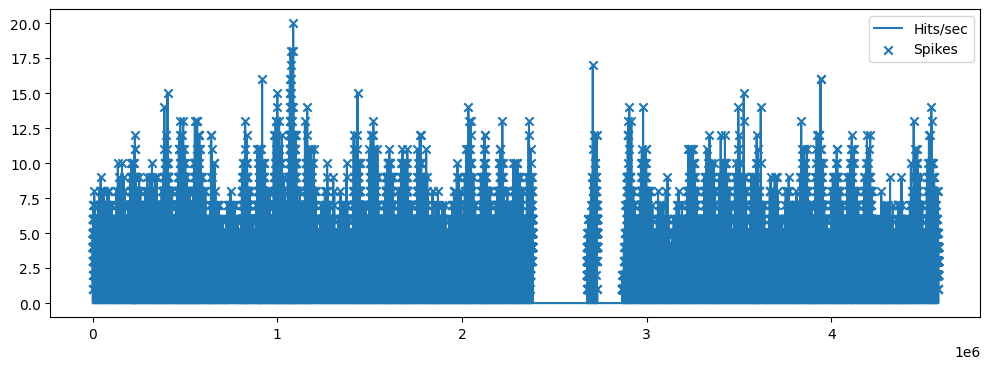

In [29]:
metrics = pd.DataFrame({
    "hits_per_sec": hits_per_sec,
    "error_rate": error_rate,
    "is_spike": spikes
})

metrics = metrics.fillna(0)
metrics = metrics.reset_index()

plt.figure(figsize=(12,4))
plt.plot(metrics.index, metrics["hits_per_sec"], label="Hits/sec")
plt.scatter(metrics[metrics.is_spike].index,
            metrics[metrics.is_spike]["hits_per_sec"],
            marker="x", label="Spikes")
plt.legend()
plt.show()

#### Forecasting

In [ ]:
train_time.head(1)

,status_label,time,size
0,Error,1995-07-02 00:55:00,0.000000
1,Error,1995-07-02 00:56:00,0.000000
2,Error,1995-07-02 00:57:00,0.000000
3,Error,1995-07-02 00:58:00,0.000000
4,Error,1995-07-02 00:59:00,0.000000
...,...,...,...
379940,Success,1995-08-22 23:55:00,24594.307692
379941,Success,1995-08-22 23:56:00,20766.714286
379942,Success,1995-08-22 23:57:00,13396.400000
379943,Success,1995-08-22 23:58:00,17693.625000


In [ ]:
test_time.head(1)

#### Some ARIMA, SARIMAX might help 

In [25]:
result = adfuller(train_time['size'])

print(f"The ADFuller yields the test statistic {result[0]} and the p-value {result[1]}, which means the series is {'non-' if result[1] > 0.05 else ''}stationary")

The ADFuller yields the test statistic -4.226282246698696 and the p-value 0.0005945586881635197, which means the series is stationary


In [13]:
def acf_pacf(series):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    plot_acf(series, ax=axes[0], lags=30, title='ACF')
    plot_pacf(series, ax=axes[1], lags=30, title='PACF')
    axes[0].set_ylim(-0.5, 0.5)
    axes[1].set_ylim(-0.5, 0.5)
    plt.tight_layout()

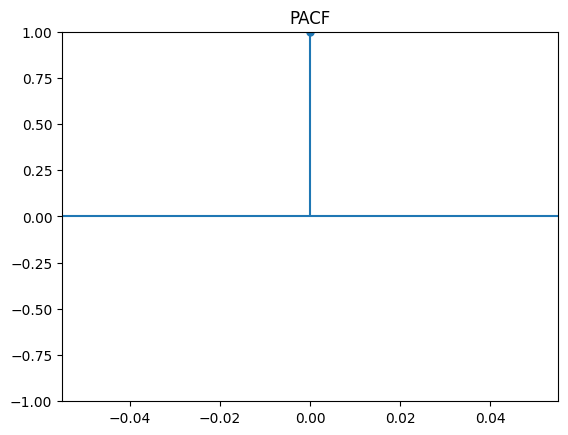

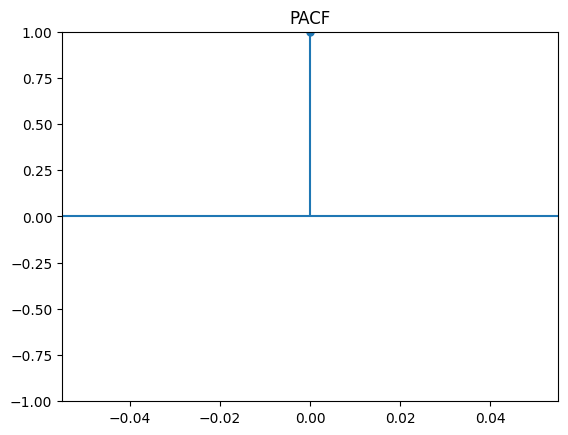

In [26]:
plot_pacf(train['size'], lags=30, title='PACF')

In [28]:
def plot_prediction(train:pd.DataFrame = train, test:pd.DataFrame = test, col:str = 'size', pred:str = None):
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=train[date_col], y=train[col], label='Train')
    sns.lineplot(x=test[date_col], y=test[col], label='Test')
    sns.lineplot(x=test[date_col], y=pred, label='Prediction')
    plt.tight_layout()
    
    y_true = test[col].values
    y_pred = np.asarray(pred)

    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse}, MAPE: {mape}, R2: {r2}')

In [29]:
def arima(p,d,q, col): 
    arima = ARIMA(train[col], order=(p, d, q)).fit()

    pred = arima.forecast(steps = len(test))

    plot_prediction(train = train, test = test, col = col, pred = pred)

In [ ]:
arima(1,0,1, col = 'size')

In [32]:
def for_dl_input_lstm(series, window_size=60):
    series = np.asarray(series, dtype=np.float32)
    
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    
    X = np.array(X).reshape(-1, window_size, 1)  # Shape: (samples, window_size, 1) - 3D for LSTM
    y = np.array(y)
    
    return X, y

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden=64, mlp_hidden1=32, mlp_hidden2=16,
        output_size=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden,
        batch_first=True, num_layers=2, dropout=dropout)
        self.mlp = nn.Sequential(
        nn.Linear(lstm_hidden, mlp_hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden1, mlp_hidden2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden2, output_size)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x) # output shape: (batch, seq_len, lstm_hidden)
        last_out = lstm_out[:, -1, :] # take last time step
        return self.mlp(last_out)


In [43]:
X_train, y_train = for_dl_input_lstm(train_time['size'])
X_test, y_test = for_dl_input_lstm(test_time['size'])

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
model = LSTM(input_size=X_train.shape[-1], output_size=1, dropout=0.1)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    preds = model(X_train_tensor)
    loss = criterion(preds, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor)
    
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R^2: {r2:.4f}')
print(f'MSE: {mse:.4f}')